In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('../../input/dataset.csv')
# sub = pd.read_csv('../../input/submission.csv')
df.head()

,WindNumber,Time,WindSpeed,Power,RotorSpeed
0,1,2017/11/1 0:20,4.188333,65.750000,5.779167
1,1,2017/11/1 0:30,4.042500,120.700000,8.636500
2,1,2017/11/1 0:40,4.137368,135.157895,8.668421
3,1,2017/11/1 0:50,4.274737,157.315789,8.727895
4,1,2017/11/1 1:00,4.108947,129.894737,8.656842


In [3]:
res = df.loc[df['WindNumber'] == 2, :]
df1 = res.drop_duplicates()

res.shape[0], df1.shape[0]

(38855, 38795)

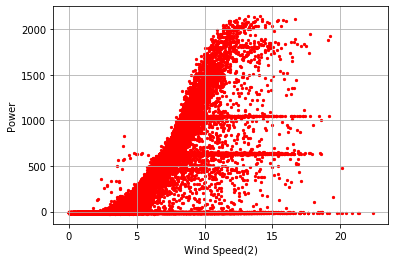

In [4]:
fig = plt.figure()
plt.scatter(df1['WindSpeed'], df1['Power'], s=5, c='r', cmap='viridis')
plt.xlabel('Wind Speed(2)')
plt.ylabel('Power')
plt.grid()
plt.show()

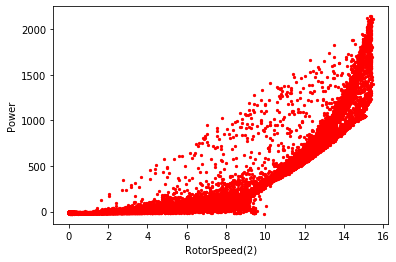

In [5]:
fig = plt.figure()
plt.scatter(df1['RotorSpeed'], df1['Power'], s=5, c='r', cmap='viridis')
plt.xlabel('RotorSpeed(2)')
plt.ylabel('Power')
plt.show()

In [6]:
# fig = plt.figure(figsize=(20, 15))

# for i in range(1, 13):
#     plt.subplot(3, 4, i)
#     plt.scatter(df.loc[df['WindNumber'] == i, :]['WindSpeed'], df.loc[df['WindNumber'] == i, :]['Power'], s=5, c='r', cmap='viridis')
#     plt.xlabel('Wind Speed({})'.format(i))
#     plt.ylabel('Power')
# plt.show()

In [7]:
df1.head()

,WindNumber,Time,WindSpeed,Power,RotorSpeed
40727,2,2017/11/1 0:10,4.637895,103.631579,8.580000
40728,2,2017/11/1 0:20,4.768500,160.050000,8.732000
40729,2,2017/11/1 0:30,4.407222,166.722222,8.727222
40730,2,2017/11/1 0:40,4.276000,152.533333,8.688667
40731,2,2017/11/1 0:50,4.142105,98.000000,8.571053


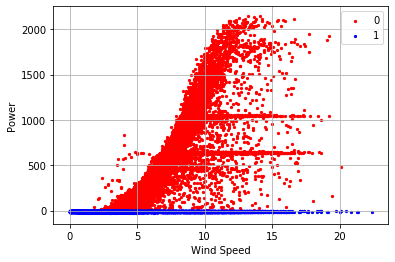

In [8]:
data0 = df1.copy()
data0['label_0'] = np.where(data0['Power'] < 0, 1, 0)

fig = plt.figure()
data_0 = data0.loc[data0['label_0'] == 0, :]
data_1 = data0.loc[data0['label_0'] == 1, :]
plt.scatter(data_0['WindSpeed'], data_0['Power'], s=5, c='r', cmap='viridis', label='0')
plt.scatter(data_1['WindSpeed'], data_1['Power'], s=5, c='b', cmap='viridis', label='1')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.grid()
plt.legend(loc='best')
plt.show()

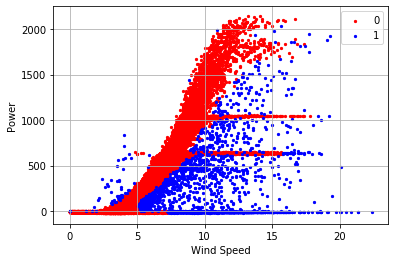

In [9]:
tmp = df1.sort_values(by='Power')
tmp['Power_bins'] = pd.cut(tmp['Power'], 90, labels=range(1, 91))

data1 = pd.DataFrame()
for i in range(1, 91):
    bin = tmp.loc[tmp['Power_bins'] == i, :]
    q1 = bin['WindSpeed'].quantile(0.25)
    q3 = bin['WindSpeed'].quantile(0.75)
    iqr = q3 - q1
    left = q1 - 1.5 * iqr
    right = q3 + 1.5 * iqr
    bin['label_1'] = bin['WindSpeed'].apply(lambda x: 1 if x < left or x > right else 0).astype(int)
    data1 = pd.concat([data1, bin], axis=0, ignore_index=True)
    data1.drop('Power_bins', axis=1, inplace=True)
    
fig = plt.figure()
ax = fig.gca()
data_0 = data1.loc[data1['label_1'] == 0, :]
data_1 = data1.loc[data1['label_1'] == 1, :]
plt.scatter(data_0['WindSpeed'], data_0['Power'], s=5, c='r', cmap='coolwarm', label='0')
plt.scatter(data_1['WindSpeed'], data_1['Power'], s=5, c='b', cmap='coolwarm', label='1')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.grid()
plt.legend(loc='best')
plt.show()

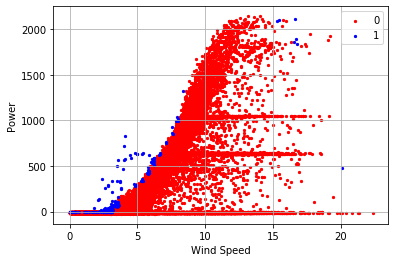

In [10]:
tmp = df1.sort_values(by='WindSpeed')
tmp['WindSpeed_bins'] = pd.cut(tmp['WindSpeed'], 50, labels=range(1, 51))

data2 = pd.DataFrame()
for i in range(1, 51):
    bin = tmp.loc[tmp['WindSpeed_bins'] == i, :]
    q1 = bin['Power'].quantile(0.25)
    q3 = bin['Power'].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    bin['label_2'] = bin['Power'].apply(lambda x: 1 if x > high else 0).astype(int)
    data2 = pd.concat([data2, bin], axis=0, ignore_index=True)
    data2.drop('WindSpeed_bins', axis=1, inplace=True)

fig = plt.figure()
data_0 = data2.loc[data2['label_2'] == 0, :]
data_1 = data2.loc[data2['label_2'] == 1, :]
plt.scatter(data_0['WindSpeed'], data_0['Power'], s=5, c='r', cmap='viridis', label='0')
plt.scatter(data_1['WindSpeed'], data_1['Power'], s=5, c='b', cmap='viridis', label='1')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.grid()
plt.legend(loc='best')
plt.show()

In [11]:
data = pd.merge(data0, data1, on=['WindNumber', 'Time', 'WindSpeed', 'Power', 'RotorSpeed'], how='inner')
data = pd.merge(data, data2, on=['WindNumber', 'Time', 'WindSpeed', 'Power', 'RotorSpeed'], how='inner')
data['label'] = data.apply(lambda x: 1 if x['label_0'] == 1 or x['label_1'] == 1 or x['label_2'] == 1 else 0, axis=1)
data.drop(['label_0', 'label_1', 'label_2'], axis=1, inplace=True)
data.head()

,WindNumber,Time,WindSpeed,Power,RotorSpeed,label
0,2,2017/11/1 0:10,4.637895,103.631579,8.580000,0
1,2,2017/11/1 0:20,4.768500,160.050000,8.732000,0
2,2,2017/11/1 0:30,4.407222,166.722222,8.727222,0
3,2,2017/11/1 0:40,4.276000,152.533333,8.688667,0
4,2,2017/11/1 0:50,4.142105,98.000000,8.571053,0


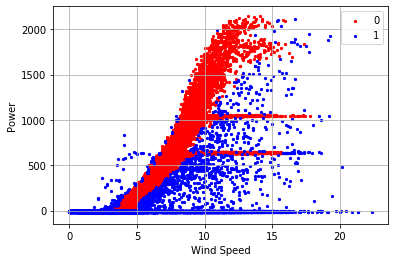

In [12]:
fig = plt.figure()
data_0 = data.loc[data['label'] == 0, :]
data_1 = data.loc[data['label'] == 1, :]
plt.scatter(data_0['WindSpeed'], data_0['Power'], s=5, c='r', cmap='viridis', label='0')
plt.scatter(data_1['WindSpeed'], data_1['Power'], s=5, c='b', cmap='viridis', label='1')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.grid()
plt.legend(loc='best')
plt.show()

3.1375 17.7745


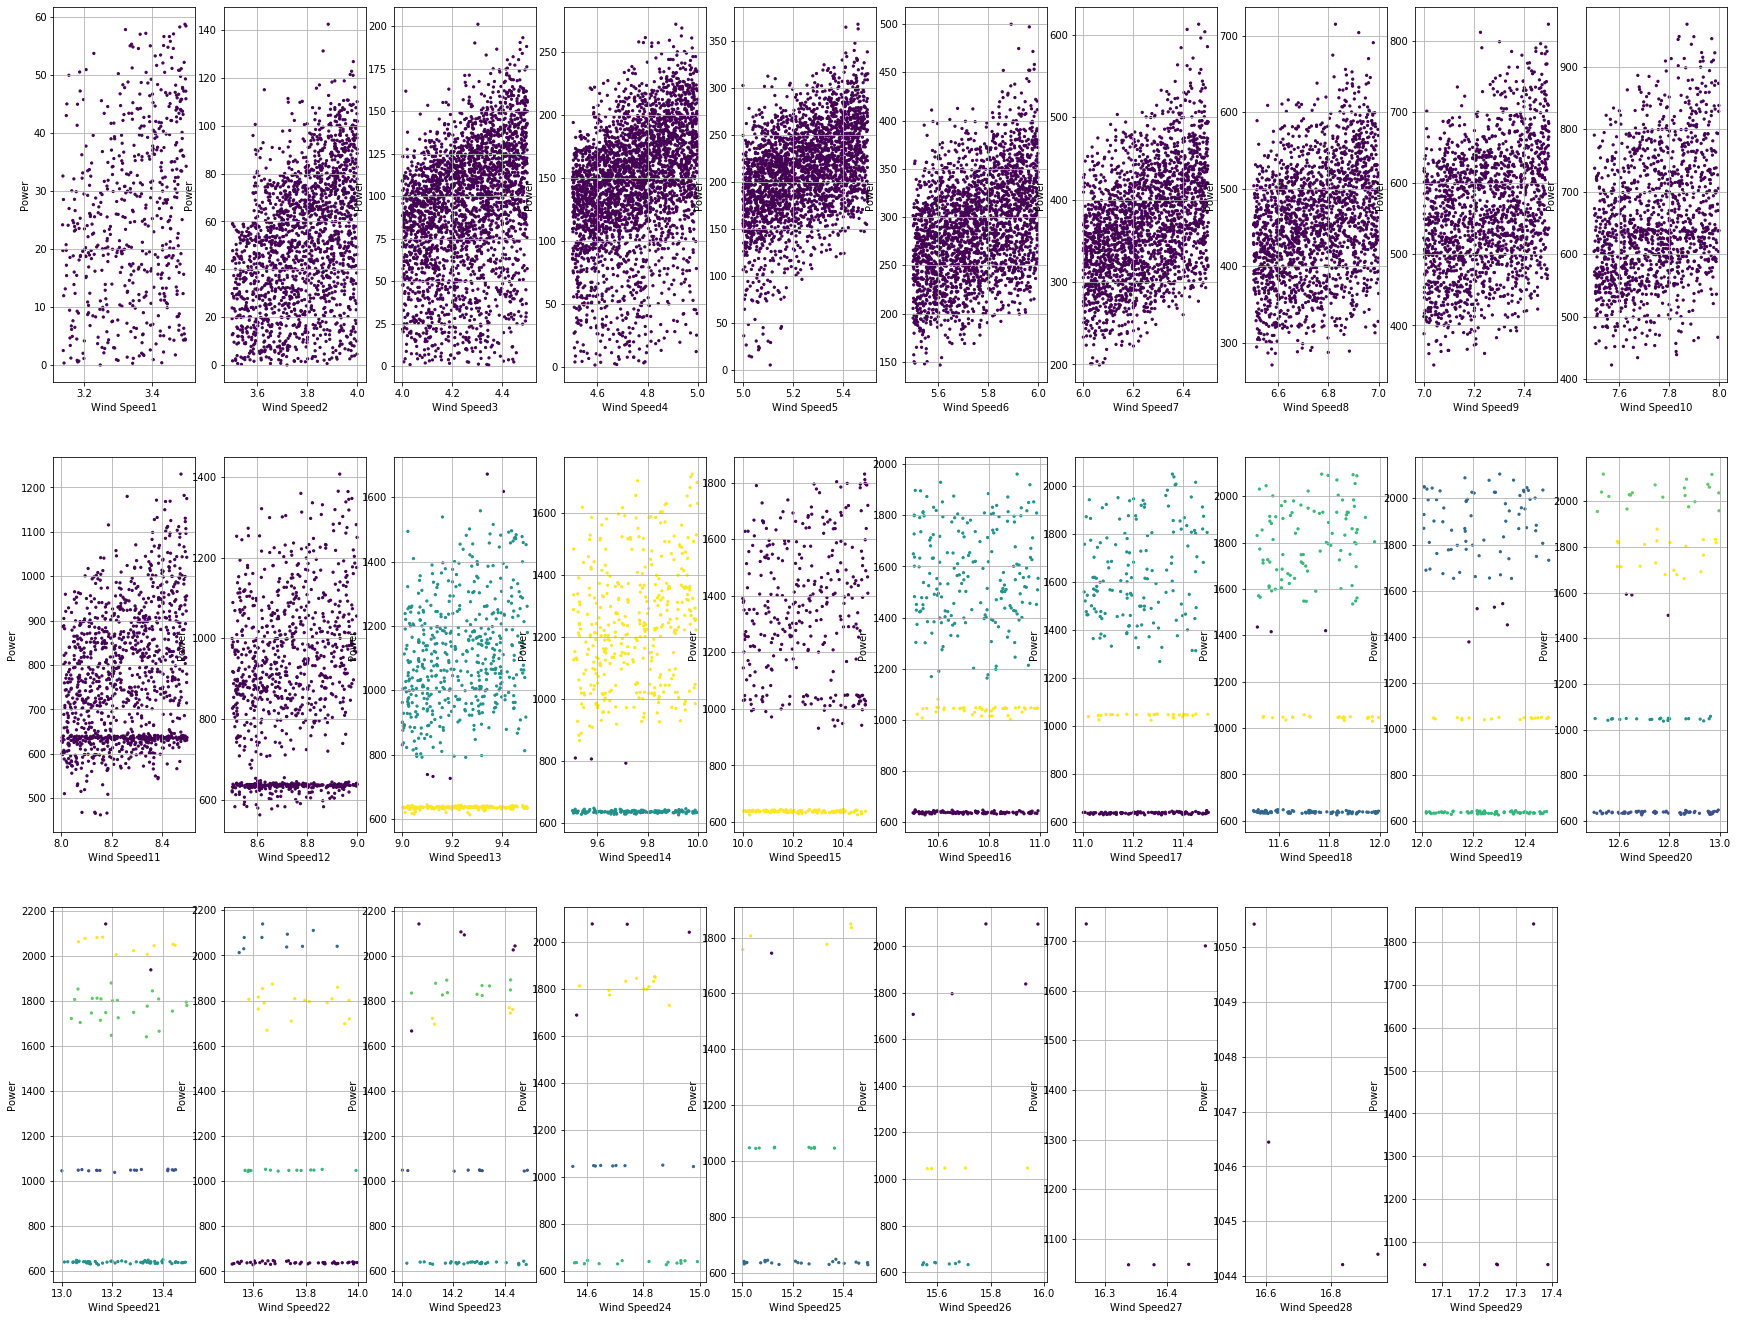

In [13]:
db_data = data_0.drop('label', axis=1).sort_values(by='WindSpeed').copy()
print(db_data['WindSpeed'].min(), db_data['WindSpeed'].max())
db_data['WindSpeed_bins'] = pd.cut(db_data['WindSpeed'], bins=list(np.arange(3, 18, 0.5)), labels=range(1, 30))

data3 = pd.DataFrame()
plt.figure(figsize=(30, 40))
for i in range(1, 30):
    # print('--------{}---------'.format(i))
    bin = db_data.loc[db_data['WindSpeed_bins'] == i, :]
    model = DBSCAN(eps=50, min_samples=5).fit(bin[['WindSpeed', 'Power']])
    # print('labels', i, np.unique(model.labels_))
    bin['label_3'] = model.labels_
    plt.subplot(5, 10, i)
    plt.scatter(bin['WindSpeed'], bin['Power'], s=5, c=bin['label_3'], cmap='viridis')
    plt.xlabel('Wind Speed{}'.format(i))
    plt.ylabel('Power')
    plt.grid()
    data3 = pd.concat([data3, bin], axis=0, ignore_index=True)
plt.show()

3.1375 17.7745


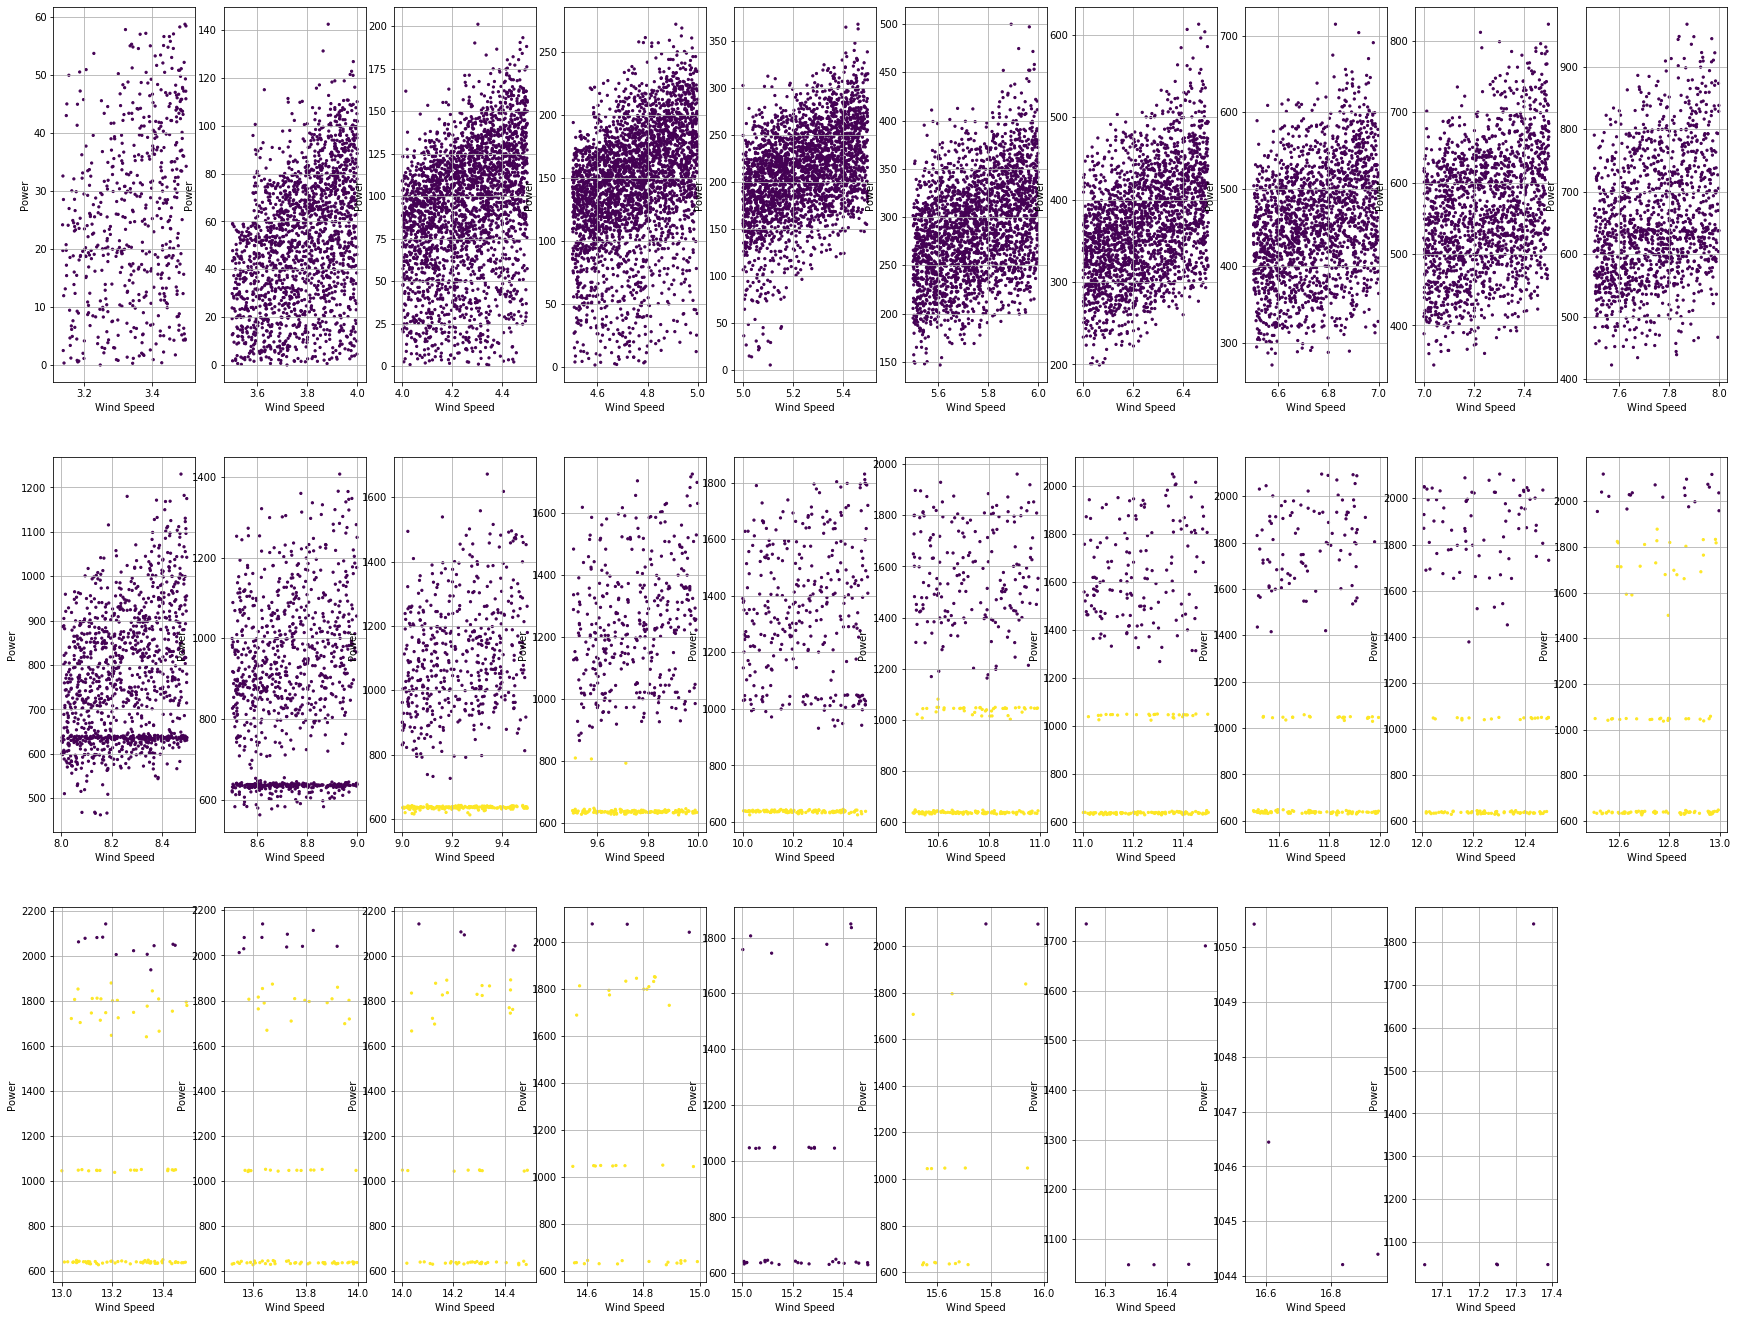

In [14]:
db_data = data_0.drop('label', axis=1).sort_values(by='WindSpeed').copy()
print(db_data['WindSpeed'].min(), db_data['WindSpeed'].max())
db_data['WindSpeed_bins'] = pd.cut(db_data['WindSpeed'], bins=list(np.arange(3, 18, 0.5)), labels=range(1, 30))

data3 = pd.DataFrame()
plt.figure(figsize=(30, 40))
for i in range(1, 30):
    # print('--------{}---------'.format(i))
    bin = db_data.loc[db_data['WindSpeed_bins'] == i, :]
    model = DBSCAN(eps=50, min_samples=5).fit(bin[['WindSpeed', 'Power']])
    # print('labels', i, np.unique(model.labels_))
    if i in [13]:
        bin['label_3'] = bin['Power'].apply(lambda x: 1 if x < 700 else 0)
    elif i in [14]:
        bin['label_3'] = bin['Power'].apply(lambda x: 1 if x < 830 else 0)
    elif i in [15]:
        bin['label_3'] = bin['Power'].apply(lambda x: 1 if x < 800 else 0)
    elif i in [16, 17, 18, 19]:
        bin['label_3'] = bin['Power'].apply(lambda x: 1 if x < 1100 else 0)
    elif i in [18]:
        bin['label_3'] = bin['Power'].apply(lambda x: 1 if x < 1500 else 0)
    elif i in [19]:
        bin['label_3'] = bin['Power'].apply(lambda x: 1 if x < 1600 else 0)
    elif i in [20, 21, 22, 23, 24]:
        bin['label_3'] = bin['Power'].apply(lambda x: 1 if x < 1900 else 0)
    elif i in [26]:
        bin['label_3'] = bin['Power'].apply(lambda x: 1 if x < 2000 else 0)
    elif i in [25, 27, 28, 29]:
        bin['label_3'] = 1
    else:
        bin['label_3'] = 0
    plt.subplot(5, 10, i)
    plt.scatter(bin['WindSpeed'], bin['Power'], s=5, c=bin['label_3'], cmap='viridis')
    plt.xlabel('Wind Speed')
    plt.ylabel('Power')
    plt.grid()
    data3 = pd.concat([data3, bin], axis=0, ignore_index=True)
plt.show()

In [15]:
data3.head()

,WindNumber,Time,WindSpeed,Power,RotorSpeed,WindSpeed_bins,label_3
0,2,2018/8/27 20:30,3.137500,24.200000,8.668000,1,0
1,2,2018/10/11 1:40,3.138235,19.764706,8.685294,1,0
2,2,2018/9/29 20:10,3.138500,32.600000,8.675500,1,0
3,2,2018/10/22 21:00,3.139375,2.562500,7.700625,1,0
4,2,2018/9/21 3:50,3.140000,28.555556,8.185000,1,0


In [16]:
data = pd.merge(data, data3, on=['WindNumber', 'Time', 'WindSpeed', 'Power', 'RotorSpeed'], how='left').fillna(1)
data['label_4'] = data.apply(lambda x: 1 if x['label'] == 1 or x['label_3'] == 1 else 0, axis=1)
data.drop(['label', 'label_3'], axis=1, inplace=True)
data.rename(columns={'label_4': 'label'}, inplace=True)
data.head()

,WindNumber,Time,WindSpeed,Power,RotorSpeed,WindSpeed_bins,label
0,2,2017/11/1 0:10,4.637895,103.631579,8.580000,4,0
1,2,2017/11/1 0:20,4.768500,160.050000,8.732000,4,0
2,2,2017/11/1 0:30,4.407222,166.722222,8.727222,3,0
3,2,2017/11/1 0:40,4.276000,152.533333,8.688667,3,0
4,2,2017/11/1 0:50,4.142105,98.000000,8.571053,3,0


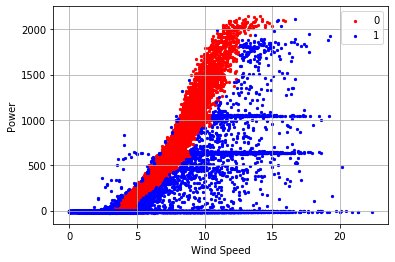

In [17]:
fig = plt.figure()
data_0 = data.loc[data['label'] == 0, :]
data_1 = data.loc[data['label'] == 1, :]
plt.scatter(data_0['WindSpeed'], data_0['Power'], s=5, c='r', cmap='viridis', label='0')
plt.scatter(data_1['WindSpeed'], data_1['Power'], s=5, c='b', cmap='viridis', label='1')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.grid()
plt.legend(loc='best')
plt.show()

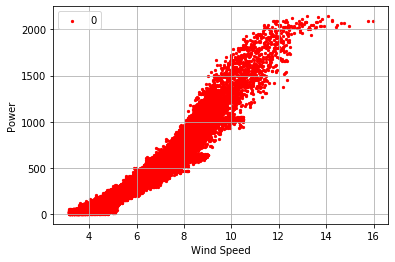

In [18]:
fig = plt.figure()
plt.scatter(data_0['WindSpeed'], data_0['Power'], s=5, c='r', cmap='viridis', label='0')
plt.xlabel('Wind Speed')
plt.ylabel('Power')
plt.grid()
plt.legend(loc='best')
plt.show()

In [19]:
res = res.merge(data, on=['WindNumber', 'Time', 'WindSpeed', 'Power', 'RotorSpeed'], how='left')
res[['WindNumber', 'Time', 'label']].to_csv('WindNumber2.csv', index=False)
res.shape[0]

38855